# Part 1

The following code represents a simple, inefficient pattern search that might be found during EDA in a jupyter notebook.

In a separate `.py` file, refactor this code using OOP to make it more extensible and efficient.

Your object should be able to do each of the following:

1. Accept either a string or a list of words as input text to be searched for pattern matches (if a string is passed, only words in the string that match the pattern should be caught)
2. Allow for registering an arbitrary number of pattern groups to search input text
3. Allow the user to specify a specific pattern group to search the text for matches
4. Allow the user to search input text with all registered patterns and return all matches by pattern group

In [1]:
my_words = ['dog', 'cat', 'mouse', 'bird', 'snake', 'kitten', 'puppy']

pattern_1_words = []
pattern_2_words = []

pattern_group_1 = [
	'at',
	'ou'
]

pattern_group_2 = [
	'in',
	'mo'
]

for word in my_words:
	for pat in pattern_group_1:
		if pat in word:
			pattern_1_words.append(word)
for word in my_words:
	for pat in pattern_group_2:
		if pat in word:
			pattern_2_words.append(word)

print(f"Pattern 1: {pattern_1_words}")
print(f"Pattern 2: {pattern_2_words}")

Pattern 1: ['cat', 'mouse']
Pattern 2: ['mouse']


\#########################################################

### Note: The .py file created is main.py and can be found on this repository: https://github.com/nicolascarva/Recycling-Partnership-Takehome.git

Instructions for running it:

1. Instantiate object with text to be searched (string or list) as input:
`input = Match('example text')`

2. Add desired pattern groups by running add_patterns method and using a dictionary with the pattern name as key and a list of the patterns as values. More pattern groups can be added as desired.

`pattern_group_1 = {'pat_1': ['ex', 'am'], 'pat_2': ['xt']}
pattern_group_2 = {'pat_3': ['foo']}
input.add_patterns(pattern_groups1)
input.add_patterns(pattern_groups2)`

3. To find matches run the match_patterns method with a list of the names of the desired pattern groups as input (if empty, default is 'all'):

`input.match_patterns(['pat_1'])`

4. If new text needs to be searched, a new object may be instantiated, or, to avoid having to add patterns again, run the change_text method with new text (string or list) as the input:

`input.change_text(['new', 'text'])` or 
`input.change_text('new text')`


\############################################################

# Part 2

Writes tests for your code using `pytest`

#### To run test: clone the repository and run 
`python -m pytest` in the environment. Test can be found in the `test_class.py` file.

############################################################

# Part 3

Imagine your job is to help build the text processing pipeline for a machine learning model. This model takes strings, processes them into vectors, and then classifies the text as relating to one of several categories (a multiclass classifier).

The raw data that is passed into the machine learning pipeline has strings that may include descriptions of many items, including multiple items that we are seeking to classify, as well as descriptions of items that are irrelevant to our classifier. These must be separated before being passed to classifier.

As the newest member of the team, your job is to get up to speed with the data as quickly as possible, and to find opportunities to improve the text processing pipeline. Perform an EDA on the following CSV to accomplish this. Be prepared to explain what insights you learned from the data, and what approaches you might use to improve the pipeline.

Perform the analysis in this notebook, below this prompt.

# Analysis

In [2]:
## Imports ##
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

import spacy

import gensim
import gensim.corpora as corpora

import pyLDAvis
import pyLDAvis.gensim_models

In [3]:
%%capture
!python -m spacy download en_core_web_sm 
nlp = spacy.load("en_core_web_sm");

First we'll import the csv data and take a look at it.

In [4]:
df = pd.read_csv('./data/takehome.csv', index_col='id')
pd.set_option('display.max_colwidth', 32)
df.head()

,text,added_datetime,yes_no,image_coordinates,image_url,original_id,page_number,parser_version,model_version,manual_override
id,,,,,,,,,,
462548,No plastic bags or pesticide...,2021-07-13 01:18:01.983,no,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN
462549,No paint or aerosol cans .,2021-07-13 01:18:01.983,no,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN
462550,Tin and aluminum food and dr...,2021-07-13 01:18:01.983,yes,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN
462551,Corrugated and non corrugate...,2021-07-13 01:18:01.983,yes,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN
462552,Includes all colors office p...,2021-07-13 01:18:01.983,yes,{'originalSize': {'height': ...,NaN,NaN,NaN,NaN,NaN,NaN


There's not a lot of context in the data and many of the columns seem to be mainly null (below). There is a yes/no column that seems to be correlated to the text, my initial assumption is that it describes if the text specifies a material (YES) or excludes a material (NO). So we'll keep the index column, the text column and the yes_no column. The rest of the columns need more information or context, so we'll leave them out of the analysis for now.

We check for null in the text column and drop those rows as well as the rows that won't be analyzed.

In [5]:
df.isnull().sum()

text                    3
added_datetime          0
yes_no                  0
image_coordinates     660
image_url            1000
original_id          1000
page_number          1000
parser_version        340
model_version         340
manual_override       340
dtype: int64

In [6]:
df = df[['text', 'yes_no']]
df.dropna(subset=['text'], inplace=True)
df.isnull().sum()

text      0
yes_no    0
dtype: int64

In [7]:
df.shape

(997, 2)

In [8]:
df.head()

,text,yes_no
id,,
462548,No plastic bags or pesticide...,no
462549,No paint or aerosol cans .,no
462550,Tin and aluminum food and dr...,yes
462551,Corrugated and non corrugate...,yes
462552,Includes all colors office p...,yes


Now we are going to clean the text to remove unwanted characters and be able to compare word counts and do other data manipulation.

In [9]:
def clean_text(text):
    """
    Accepts a single text document and performs several regex
    substitutions in order to clean the document.
    Parameters
    ----------
    text: string
    Returns
    -------
    text: list of words
    """
    special_chars_regex = '[:?,.>$|!\'"]'
    white_spaces_regex = '[ ]{2,}'
    text = re.sub('[^a-zA-Z ]', " ", text)
    text = re.sub(special_chars_regex, " ", text)
    text = re.sub(white_spaces_regex, " ", text)
    return text

In [10]:
df['text'] = [clean_text(text) for text in df['text']]

Let's look at how many words each row contains. Makes sense that there would be a correlation between the number of materials in the classification and the number of words in the text. We'll add that data as a column and plot the histogram. We can see that the vast majority of text is under 10 words. Maybe this would be useful in the future (ie. applying different models, or manually reviewing rows with the long text).

(array([  2., 159., 196.,  71.,  62., 238.,  34.,  34.,  19.,  17.,  12.,
         12.,  11.,  12.,   7.,  10.,   7.,   9.,   4.,   8.,   6.,   5.,
          3.,   2.,   1.,   2.,   3.,   0.,   9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

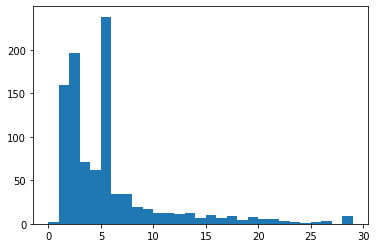

In [11]:
df['num_of_words'] = [len(text.split()) for text in df['text']]
plt.hist(df['num_of_words'],bins=range(30))

We are going to plot the most common words in a histogram by creating a Document Term Matrix with sklearn and then counting the word frequencies. We are using unigrams and bigrams for the analysis.

In [12]:
def plot_word_count(df, x):
    """
    Plots histogram of word count for given df
    ---------------
    df: Dataframe with clean 'text' column
    x: Number of words to be plotted
    """
    cv = CountVectorizer(stop_words='english', ngram_range=[1,2]) 
    cv_matrix = cv.fit_transform(df['text']) 
    # create document term matrix
    df_dtm = pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names_out())
    word_count = pd.DataFrame(index=cv.get_feature_names_out(), data=[df_dtm[feature].sum() for feature in cv.get_feature_names_out()], 
             columns=['count']).sort_values(by=['count'], axis=0, ascending=False)
    plt.figure(figsize=(18, 8), dpi=80)
    plt.bar(word_count[:x].index, word_count['count'][:x])
    return word_count

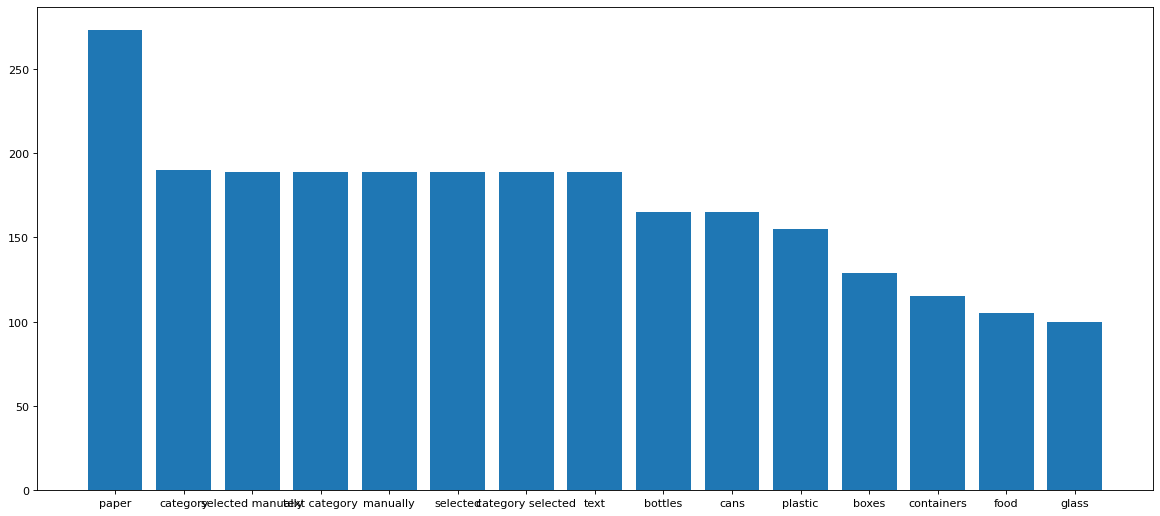

In [13]:
word_count = plot_word_count(df, 15)

We find that 'category', 'selected manually', etc. are a large part of the word count, which is odd so we look at the rows that contain 'category':

In [14]:
[(index, text) for (index, text) in zip(df.index, df['text']) if 'category' in text][:10]

[(462634,
  'Mixed Paper This category includes all other paper such as notebook paper Post it notes colored copy paper computer paper and white copy paper white envelopes green bar or blue bar computer paper junk mail etc Staples are OK '),
 (280510, 'No text category selected manually'),
 (280512, 'No text category selected manually'),
 (280573, 'No text category selected manually'),
 (306757, 'No text category selected manually'),
 (310641, 'No text category selected manually'),
 (280536, 'No text category selected manually'),
 (280537, 'No text category selected manually'),
 (280538, 'No text category selected manually'),
 (280539, 'No text category selected manually')]

We find there's quite a bit of rows with 'No text category selected manually' as their only data. With more context, it is possible this data could prove useful, but for now we'll drop these rows and re-run the analysis.

In [15]:
df = df[df['text'] != 'No text category selected manually']
df.shape

(808, 3)

Re-running the analysis, it looks as expected, the most frequent words are for objects or materials that are recyclable.

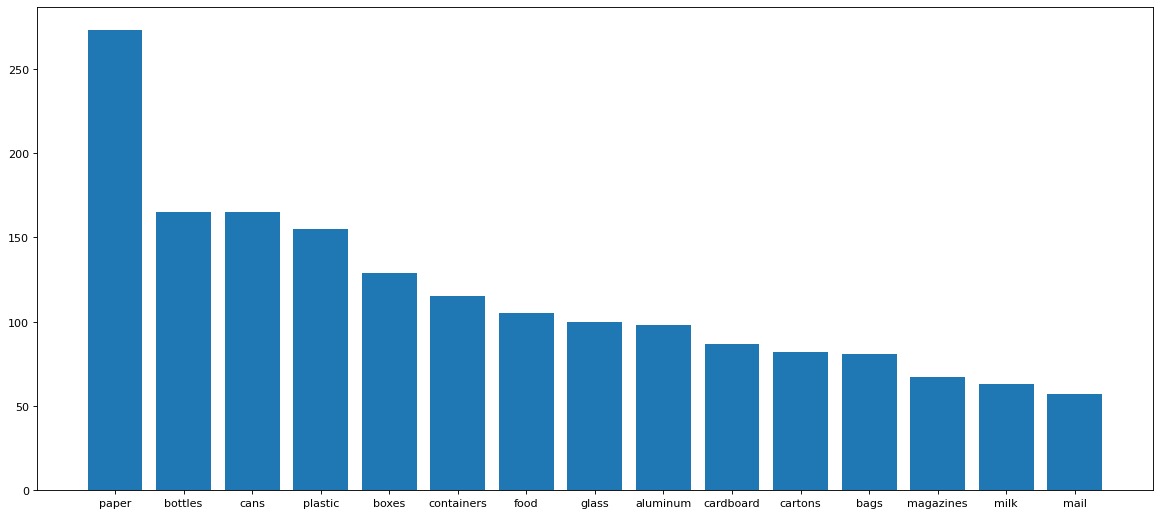

In [16]:
word_count = plot_word_count(df, 15)

We'll also run the word count per row again:

(array([  2., 159., 196.,  71.,  62.,  49.,  34.,  34.,  19.,  17.,  12.,
         12.,  11.,  12.,   7.,  10.,   7.,   9.,   4.,   8.,   6.,   5.,
          3.,   2.,   1.,   2.,   3.,   0.,   9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

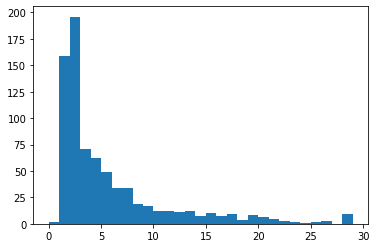

In [17]:
plt.hist(df['num_of_words'],bins=range(30))

Let's take a look at the rows with over 25 words:

In [18]:
pd.set_option('display.max_colwidth', 150)
df[df['num_of_words'] > 15].head()
df[df['num_of_words'] > 15].head()

,text,yes_no,num_of_words
id,,,
462563,Plastics such as those from Cleaners Food containers Bleach Milk Cooking oils Pill bottles Cosmetics lotions Shampoo conditioner Soft drinks Deter...,yes,26
462564,Catalogs Cereal boxes Shredded paper Mail Toilet paper rolls Frozen food boxes Greeting cards Boxboard e g pop boxes,yes,19
462565,Office paper white and colored Phonebooks Corrugated cardboard Tissue boxes Snack boxes Pop and beer cartons Wrapping paper tubes Paper gift shopp...,yes,30
462566,Newspaper advertisements Magazines Shoe boxes Paperback books Paper egg cartons Paper towel rolls Tissue paper Kraft paper bags Gable Top Containe...,yes,26
462567,Aluminum and metal cans foil and foil trays lids and aerosol spray cans must be empty Please,yes,17


We'll separate the yes and no rows in two different dataframes for later analysis

In [19]:
df_yes = df.loc[df['yes_no'] == 'yes']
df_no = df.loc[df['yes_no'] == 'no']
print(df_yes.shape)
print(df_no.shape)

(681, 3)
(127, 3)


Let's run the word-count analysis for df_no, it'd be interesting to see what is being excluded. 

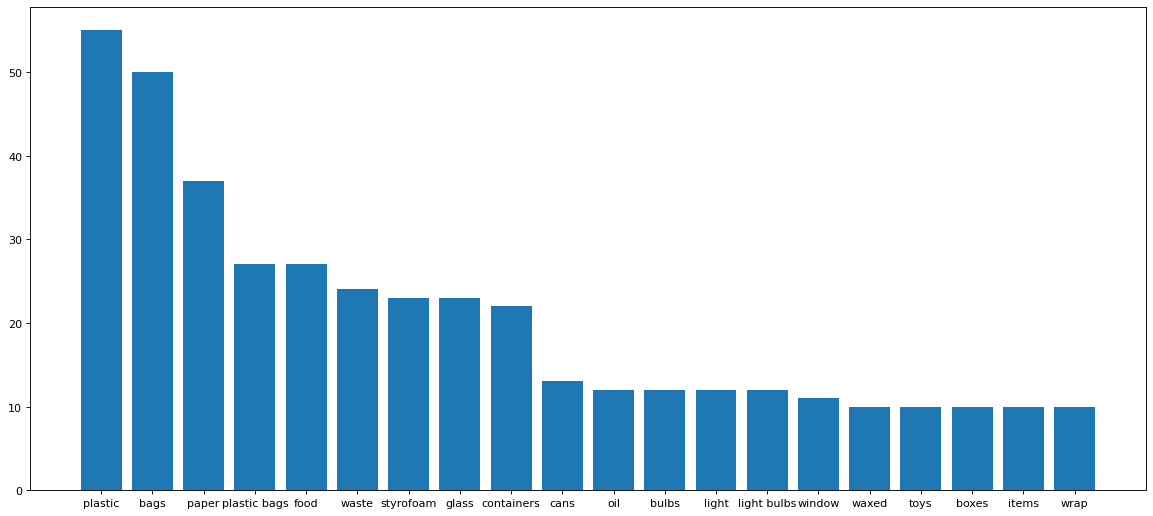

In [20]:
word_count = plot_word_count(df_no, 20)

As expected, many of the most common words are of non-recyclable materials (food, waste, oil, etc.), though the most common words are recyclable materials, which probably means they go in a different bin. Let's take a look at the most commonly used bi-grams.

In [21]:
word_count[word_count.index.str.contains(' ')][:10]

,count
plastic bags,27
light bulbs,12
window glass,8
food waste,8
motor oil,6
waxed paper,6
wrapping paper,5
bags plastic,5
aerosol cans,5
pizza boxes,5


# LDA

We'll apply LDA to df_yes and df_no separately to see which words tend to appear together on each.

In [22]:
def tokenize(doc):
# run the clean_data function on the text
    text = clean_text(doc)
# Instantiatie language model
    doc = nlp(text)
    STOP_WORDS = nlp.Defaults.stop_words.union('', 'the', 'this', '-pron-', 'no ', 'non' )
    return [token.lemma_.lower().lstrip().rstrip() for token in doc 
            if (token.text not in STOP_WORDS) 
            and (token.is_punct != True)
            and (token.text not in '')
            and (len(token.text)>1)]

def apply_lda(df):
    # prepare data for LDA model
    lemmas = [tokenize(text) for text in df['text'] ]
    #Prepare bag of words
    id2words = corpora.Dictionary(lemmas)
    corpus = [id2words.doc2bow(lemma) for lemma in lemmas]
    # prepare model
    lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2words,
                                                        num_topics=3,
                                                        chunksize=25,
                                                        passes=100,
                                                        per_word_topics=True,
                                                        workers=6)
    return lda_multicore, corpus, id2words

## df_yes LDA

In [23]:
lda_multicore, corpus, id2words = apply_lda(df_yes)

In [24]:
# run visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore, corpus, id2words)
vis

c:\users\ncarv\.virtualenvs\recycling-partnership-takehome-7fp9ueh8\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.112569  0.201482       1        1  36.126635
1     -0.269557 -0.020981       2        1  35.800095
0      0.156987 -0.180501       3        1  28.073270, topic_info=          Term        Freq       Total Category  logprob  loglift
21       paper  212.000000  212.000000  Default  30.0000  30.0000
1          can  108.000000  108.000000  Default  29.0000  29.0000
52     plastic  117.000000  117.000000  Default  28.0000  28.0000
0     aluminum   84.000000   84.000000  Default  27.0000  27.0000
5          box  106.000000  106.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
119    bottles    8.406489   18.474204   Topic3  -4.8763   0.4830
101      clean   11.398050   31.222665   Topic3  -4.5718   0.2627
8    corrugate    7.590708   16.760487   Topic3  -4.9784   0.4783
31   container   10.842135   76.497310   Topic3  -4.6218  -0.6835
11     include    6.839818   23.978186   Topic3  -5.0825   0.0160

[163 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
210       1  0.072814   accept
210       2  0.655322   accept
210       3  0.218441   accept
92        3  0.913835  aerosol
100       1  0.321327      all
...     ...       ...      ...
264       1  0.187932       we
264       3  0.751727       we
78        2  0.979450    white
35        1  0.975314     wine
114       1  0.985214   yogurt

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

While the results are different each time the LDA is run, it appears the 3 topics are separated into paper, metal, and plastic; with some overlap between them.

## df_no LDA

In [25]:
lda_multicore, corpus, id2words = apply_lda(df_no)

In [26]:
# run visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore, corpus, id2words)
vis

c:\users\ncarv\.virtualenvs\recycling-partnership-takehome-7fp9ueh8\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.035210 -0.106599       1        1  48.046976
2     -0.124127  0.026873       2        1  29.266127
0      0.088918  0.079726       3        1  22.686897, topic_info=       Term       Freq      Total Category  logprob  loglift
2        no  18.000000  18.000000  Default  30.0000  30.0000
54    paper  27.000000  27.000000  Default  29.0000  29.0000
43     bags  11.000000  11.000000  Default  28.0000  28.0000
63      box   7.000000   7.000000  Default  27.0000  27.0000
9     glass  20.000000  20.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
21  grocery   1.553519   3.526676   Topic3  -5.0837   0.6635
9     glass   3.615744  20.719607   Topic3  -4.2389  -0.2624
54    paper   3.560134  27.798711   Topic3  -4.2544  -0.5718
41    waste   2.860441  18.800308   Topic3  -4.4732  -0.3995
12  ceramic   1.584343   8.336445   Topic3  -5.0640  -0.1771

[175 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
227       1  0.768881    accept
5         1  0.905674   aerosol
5         3  0.129382   aerosol
324       3  0.966763  aluminum
356       2  0.685822    animal
...     ...       ...       ...
330       2  0.914275      wood
20        1  0.611895      wrap
20        2  0.262241      wrap
20        3  0.087414      wrap
141       2  0.913222   wrapper

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

The df_no analysis is not as clear topics are not as clear, since there is a wider array of items that are excluded from recycling.

This was a preliminary EDA and a good starting point for doing a more in-depth analysis with more complex tools. With more context, and/or information of the dropped columns, even more insights could be gained into the significance of the data and how to best prepare it for Machine Learning purposes.